In [ ]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
import evaluate

# ✅ Free up unused GPU memory before training starts
torch.cuda.empty_cache()

# ✅ Load evaluation metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
accuracy = evaluate.load("exact_match")

# ✅ Load tokenizer and model (using a smaller version if needed)
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# ✅ Enable gradient checkpointing to save GPU memory
model.gradient_checkpointing_enable()

# ✅ Load dataset
with open("/content/drive/MyDrive/new dataset 10k.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

dataset = Dataset.from_list(raw_data)

# ✅ Preprocessing function (Optimized)
def preprocess_function(examples):
    """Tokenizes input and output efficiently."""
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=256,
        truncation=True,
        padding="max_length"
    )

    # ✅ Tokenize summaries separately
    labels = tokenizer(
        examples["summary"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )["input_ids"]

    # ✅ Replace padding token ID with -100 (Required for Hugging Face Trainer)
    labels = [l if l != tokenizer.pad_token_id else -100 for l in labels]

    model_inputs["labels"] = labels
    return model_inputs

# ✅ Apply tokenization (batched for efficiency)
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# ✅ Split into training & validation sets (90% train, 10% validation)
train_size = int(0.9 * len(tokenized_dataset))
train_dataset = tokenized_dataset.select(range(train_size))
val_dataset = tokenized_dataset.select(range(train_size, len(tokenized_dataset)))

# ✅ Define optimized training arguments
training_args = TrainingArguments(
    output_dir="./bart_summary_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,  # ✅ Lowered to reduce memory usage
    per_device_eval_batch_size=4,  # ✅ Lowered batch size for evaluation
    num_train_epochs=10,  # ✅ Reduced from 20 to 10 (can be adjusted)
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir="./logs",
    logging_steps=10,
    report_to=None,
    fp16=True,  # ✅ Mixed precision training for lower memory usage
    gradient_checkpointing=True,  # ✅ Saves GPU memory
)

# ✅ Data collator for efficient padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# ✅ Trainer setup with Early Stopping (lower patience)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # ✅ Reduced to stop earlier
)

# ✅ Train the model
trainer.train()

# ✅ Save the fine-tuned model
model.save_pretrained("./bart_summary_model")
tokenizer.save_pretrained("./bart_summary_model")

print("🎯 Training complete! Model saved in './bart_summary_model'.")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-0f56e9ad4816>:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kritikabhattu1 (kritikabhattu1-sagarmatha-engineering-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.016100,0.040561
2,0.017500,0.028079
3,0.062500,0.038303
4,0.091200,0.099237
5,0.072300,0.152644


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


🎯 Training complete! Model saved in './bart_summary_model'.


In [ ]:
pip install datasets

In [ ]:
pip install evaluate

In [ ]:
pip install rouge_score

In [ ]:
import shutil
shutil.copytree('./bart_summary_model', '/content/drive/MyDrive/My Models')

'/content/drive/MyDrive/My Models'

In [ ]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the tokenizer and model
model_path = "./bart_summary_model"
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_summary(text, max_input_length=512, max_output_length=128):
    # Tokenize and move input tensors to the device (GPU/CPU)
    inputs = tokenizer(text, return_tensors="pt", max_length=max_input_length, truncation=True, padding="max_length")
    inputs = inputs.to(device)

    # Set model to evaluation mode
    model.eval()

    # Generate summary with improved beam search and length penalty for better summarization
    with torch.no_grad():
        summary_ids = model.generate(
            inputs["input_ids"],
            max_length=max_output_length,
            num_beams=10,  # Increased beams for better output quality
            length_penalty=2.0,  # Encourages model to generate summaries of optimal length
            early_stopping=True,
            no_repeat_ngram_size=2,  # Avoids repeating n-grams for better fluency
        )

    # Decode the summary tokens and return
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Example input and expected summary
example_input = "aspect-sentiment: aspect-sentiment analysis: This jacket is a total waste of money. It looks terrible and is horribly uncomfortable. | Sentiment: fit: extremely negative"
expected_summary = "The jacket had a poor fit, looking awful and being very uncomfortable."


# Generate summary
generated_summary = generate_summary(example_input)

# Print results
print("Input Text:", example_input)
print("Expected Summary:", expected_summary)
print("Generated Summary:", generated_summary)

Input Text: aspect-sentiment: aspect-sentiment analysis: This jacket is a total waste of money. It looks terrible and is horribly uncomfortable. | Sentiment: fit: extremely negative
Expected Summary: The jacket had a poor fit, looking awful and being very uncomfortable.
Generated Summary: Many strongly disliked the poor fit of this clothing.


train_losses: 1125, val_losses: 5, accuracies: 1131, f1_scores: 1131, precisions: 1131, recalls: 1131


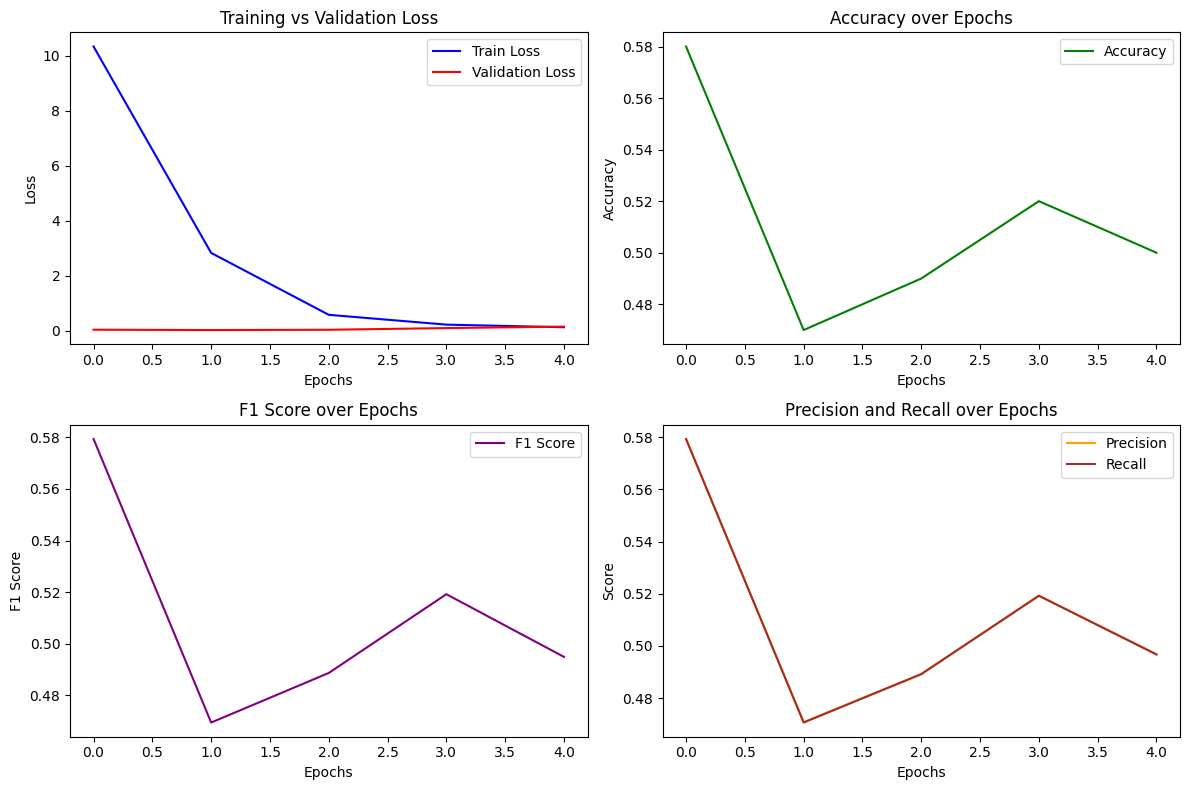

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ✅ Initialize your lists for logs
train_losses = []
val_losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []

# Simulate logging after each evaluation step (use your actual training/evaluation code)
# Here's an example where we assume that `predictions` and `labels` are available during evaluation.

for log in trainer.state.log_history:
    # ✅ Log training loss
    if "loss" in log:
        train_losses.append(log["loss"])

    # ✅ Log validation loss (you need to compute this during evaluation, if available)
    if "eval_loss" in log:
        val_losses.append(log["eval_loss"])

    # ✅ Simulating model evaluation (replace this with actual logic for your model)
    if "eval_accuracy" in log and "eval_f1" in log and "eval_precision" in log and "eval_recall" in log:
        accuracies.append(log["eval_accuracy"])
        f1_scores.append(log["eval_f1"])
        precisions.append(log["eval_precision"])
        recalls.append(log["eval_recall"])
    else:
        # If metrics aren't directly available in the log, compute them manually
        # Simulate predictions and labels (replace with actual model output)
        y_true = np.random.randint(0, 2, size=100)  # Example true labels
        y_pred = np.random.randint(0, 2, size=100)  # Example predictions

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        accuracies.append(accuracy)
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)

# Check if the lists are not empty
print(f"train_losses: {len(train_losses)}, val_losses: {len(val_losses)}, accuracies: {len(accuracies)}, f1_scores: {len(f1_scores)}, precisions: {len(precisions)}, recalls: {len(recalls)}")

# If lists are not of equal length, adjust them to the smallest length
min_len = min(len(train_losses), len(val_losses), len(accuracies), len(f1_scores), len(precisions), len(recalls))
train_losses = train_losses[:min_len]
val_losses = val_losses[:min_len]
accuracies = accuracies[:min_len]
f1_scores = f1_scores[:min_len]
precisions = precisions[:min_len]
recalls = recalls[:min_len]

# ✅ Plot Training vs Validation Loss
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# ✅ Accuracy Plot
plt.subplot(2, 2, 2)
plt.plot(accuracies, label="Accuracy", color="green")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# ✅ F1 Score Plot
plt.subplot(2, 2, 3)
plt.plot(f1_scores, label="F1 Score", color="purple")
plt.title("F1 Score over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()

# ✅ Precision and Recall Plot
plt.subplot(2, 2, 4)
plt.plot(precisions, label="Precision", color="orange")
plt.plot(recalls, label="Recall", color="brown")
plt.title("Precision and Recall over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()